# <center> SIP1 - Position Management Quantitative Model </center> 
## <center>By 0xEvan(∞)#4567</center>  

# Import Data

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from datetime import datetime, date, timedelta
from matplotlib.pyplot import figure

In [ ]:
# Mount google drive to access the dataset, which is saved on google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
csi_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/csi.csv'
ohm_backtest_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/ohm_rebase_backtest_df.csv'
ohm_market_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/olympus_market_fluidsonic.csv' 
new_csi_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/new_csi.csv'

In [ ]:
# data preprocessing

# read csv files as dataframes
csi_df = pd.read_csv(csi_file)
new_csi_df = pd.read_csv(new_csi_file)
ohm_backtest_df = pd.read_csv(ohm_backtest_file)
ohm_market_df = pd.read_csv(ohm_market_file)
ohm_market_df = ohm_market_df[['timestamp', 'indexed_price_usd']]

# set indexes
csi_df['time'] = pd.to_datetime(csi_df['time']).dt.normalize()
csi_df = csi_df.set_index('time')

new_csi_df['time'] = pd.to_datetime(new_csi_df['time']).dt.normalize()
new_csi_df = new_csi_df.set_index('time')

ohm_backtest_df = ohm_backtest_df.set_index('datetime')
ohm_backtest_df.index = pd.to_datetime(ohm_backtest_df.index)
ohm_market_df['timestamp'] = pd.to_datetime(ohm_market_df['timestamp']).dt.normalize()
ohm_market_df['timestamp'] = ohm_market_df['timestamp'].dt.tz_localize(None)
ohm_market_df = ohm_market_df.set_index('timestamp')

# drop extra columns in csi_df
csi_df = csi_df[['csi_signal_15d', 'csi_signal_30d', 'csi_signal_90d']]


# drop NaN values
csi_df = csi_df.dropna()

# trim csi rows to match ohm_backtest_df rows
ohm_backtest_df = ohm_backtest_df[ohm_backtest_df.index >= '2021-10-01']
csi_df = csi_df[csi_df.index >= '2021-09-27']
ohm_market_df = ohm_market_df[ohm_market_df.index >= '2021-10-01']


# drop last row, it's duplicate
csi_df = csi_df[:-1]
new_csi_df = new_csi_df[:-1]
# turn index from string to timestamp
# csi_df.index = csi_df.index.astype('datetime64[ns]')

In [ ]:
# define trading signal
csi_df['trade_signal'] = csi_df['csi_signal_15d'] > csi_df['csi_signal_30d'] # when 15d > 30d, sell. When 30d > 15day, buy

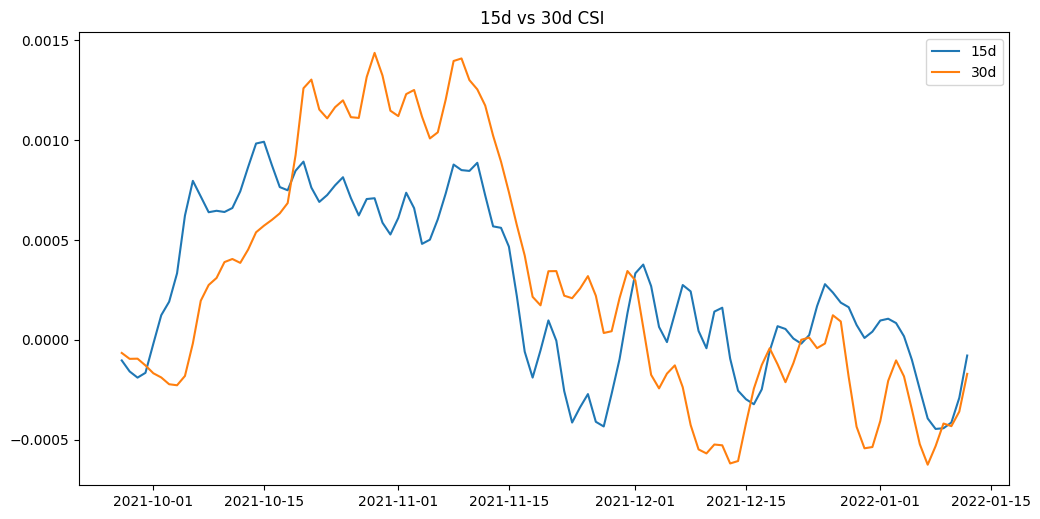

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.plot(csi_df.index, csi_df['csi_signal_15d'].cumsum(), label='15d')
plt.plot(csi_df.index, csi_df['csi_signal_30d'].cumsum(), label='30d')
plt.title('15d vs 30d CSI ');
plt.legend()
plt.show()

In [ ]:
count = 0
buy_strength = 0
buy_list = []
for index, row in csi_df.iterrows():
  count += 1
  if count < 5:
    if row['trade_signal'] == True:
      buy_strength +=1
    if row['trade_signal'] == False:
      buy_strength -= 1
  else:
    if buy_strength >= 2:
      buy_list.append((index, True))
    if buy_strength <= -2:
      buy_list.append((index, False))
    count = 0
    buy_strength = 0


In [ ]:
buy_list

[(Timestamp('2021-10-01 00:00:00'), False),
 (Timestamp('2021-10-06 00:00:00'), True),
 (Timestamp('2021-10-11 00:00:00'), False),
 (Timestamp('2021-10-16 00:00:00'), True),
 (Timestamp('2021-10-21 00:00:00'), False),
 (Timestamp('2021-10-26 00:00:00'), True),
 (Timestamp('2021-10-31 00:00:00'), False),
 (Timestamp('2021-11-10 00:00:00'), False),
 (Timestamp('2021-11-25 00:00:00'), False),
 (Timestamp('2021-11-30 00:00:00'), True),
 (Timestamp('2021-12-05 00:00:00'), True),
 (Timestamp('2021-12-10 00:00:00'), True),
 (Timestamp('2022-01-04 00:00:00'), False)]

In [ ]:
csi_df.columns

Index(['csi_signal_15d', 'csi_signal_30d', 'csi_signal_90d', 'trade_signal'], dtype='object')

In [ ]:
new_csi_df.columns

Index(['ethereum', 'bitcoin', 'stable_dom_factor', 'signal', 'signal_90d',
       'signal_60d', 'signal_30d', 'signal_15d', 'signal_90d_percentile',
       'signal_60d_percentile', 'signal_30d_percentile',
       'signal_15d_percentile'],
      dtype='object')

In [ ]:
class backtest_model:
  def __init__(self, backtest_df, model_df, buy_trade_size = .1, sell_trade_size = .1, stable_apy = .2, slippage = .0025, gas=.01):
    '''
    backtest_df = Holds data for backtesting. Needs the following columns=['ohmPrice', 'rebasePercentage']
    model_df = Contains the signal that trades will be executed on
    '''
    self.backtest_df = backtest_df
    self.model_df = model_df
    self.trades_df = None

    self.buy_trade_size = buy_trade_size
    self.sell_trade_size = sell_trade_size
    self.stable_apy = stable_apy
    self.slippage = slippage
    self.gas = gas

    self.stable_ratio_dict = {"bull":.25, "chop":.5, "bear":.75}

  def calc_portfolio_value(self, token_amount, stable, token_price):
    '''
    Rebase should be denominated in USD
    '''
    return (token_amount * token_price) + stable 

  def calc_rebase_yield(self, rebase_pos, rebase_yield):
    '''
    rebase_pos is denominated in native tokens, NOT USD
    '''
    return rebase_pos * rebase_yield

  def calc_trades(self):
    '''
    calculates trades based on self.model_df signal data. Must manually assign this to self.trades_df outside of the class. 
    Problem is noted and needs to be fixed in the future.
    '''
    count = 0
    buy_strength = 0
    buy_list = []
    for index, row in self.model_df.iterrows():
      count += 1
      if count < 5:
        if row['trade_signal'] == True:
          buy_strength +=1
        if row['trade_signal'] == False:
          buy_strength -= 1
      else:
        if buy_strength >= 2:
          buy_list.append((index, True))
        if buy_strength <= -2:
          buy_list.append((index, False))
        count = 0
        buy_strength = 0
    
    # turn list of tuples into dataframe
    df = pd.DataFrame(buy_list, columns=["datetime", "trade_signal"])
    df["datetime"] = pd.to_datetime(df["datetime"]).dt.normalize()
    df = df.set_index("datetime")
    return df


  def calc_trade_size(self):
    '''
    optimize trade towards ideal ratio
    '''
    # 1) check what kind of market we are in
    # 2) calculate optimal trade size based on market
    # 3) execute


    pass

  def run_backtest_rebase(self, token_initial, stable_initial, vanilla=False):
    sim_result = pd.DataFrame(columns=['token_amount', 'stable_amount', 'ohmPrice', 'portfolio_value'])
    # trades execution count
    trades_counter = 0
    # initial backtest data
    token_amount = token_initial
    stable_amount = stable_initial
    portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, self.backtest_df['ohmPrice'][0])

    # run through backtest data
    for index, row in self.backtest_df.iterrows():
      # update values
      rebase_yield = self.calc_rebase_yield(token_amount, row['rebasePercentage'])
      stable_yield = stable_amount * (self.stable_apy / 365)
      token_amount += rebase_yield
      stable_amount += stable_yield
      portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, row['ohmPrice'])

      if vanilla == False:
      # verify whether to trade
        # print("index", index, "self-trades_df.index", self.trades_df.index[0])
        if index == self.trades_df.index[0]:
          # print("yes", self.trades_df.index[0])
          # pop off that row
          self.trades_df = self.trades_df.tail(self.trades_df.shape[0] -1)
          trades_counter +=1
          # Execute trade
          if self.trades_df['trade_signal'][0] == True:
            # initial trade params
            order_size = stable_amount * self.buy_trade_size # trade is set at default 10% trading size
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage
            buy_size = order_size/row['ohmPrice']

            # calculate trade
            token_amount += buy_size
            stable_amount -= order_size - gas_fee - slippage_fee
          elif self.trades_df['trade_signal'][0] == False:
            # initial trade params
            order_size = stable_amount * self.sell_trade_size # trade is set at default 10% trading size
            sell_size = order_size/row['ohmPrice']
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage

            # calculate trade
            token_amount -= sell_size
            stable_amount += order_size - gas_fee - slippage_fee


      # update results
      sim_result.loc[sim_result.index.size] = (token_amount, stable_amount, row['ohmPrice'], portfolio_value)


    # finish up function
    sim_result.index = self.backtest_df.index
    print("traedes_counter", trades_counter)

    return sim_result


  def run_backtest_no_rebase(self, token_initial, stable_initial, vanilla=False):
    sim_result = pd.DataFrame(columns=['token_amount', 'stable_amount', 'indexed_price_usd', 'portfolio_value'])
    # trades execution count
    trades_counter = 0
    # initial backtest data
    token_amount = token_initial
    stable_amount = stable_initial
    portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, self.backtest_df['indexed_price_usd'][0])

    # run through backtest data
    for index, row in self.backtest_df.iterrows():
      # update values
      # rebase_yield = self.calc_rebase_yield(token_amount, row['rebasePercentage'])
      stable_yield = stable_amount * (self.stable_apy / 365)
      # token_amount += rebase_yield
      stable_amount += stable_yield
      portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, row['indexed_price_usd'])

      if vanilla == False:
      # verify whether to trade
        # print("index", index, "self_trades_df.index", self.trades_df.index[0])
        if index == self.trades_df.index[0] and self.trades_df.index.size != 0:
          # print("yes", self.trades_df.index[0])
          # pop off that row
          self.trades_df = self.trades_df.tail(self.trades_df.shape[0] -1)
          trades_counter +=1
          # Execute trade
          if self.trades_df['trade_signal'][0] == True:
            # initial trade params
            order_size = stable_amount * self.buy_trade_size # trade is set at default 10% trading size
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage
            buy_size = order_size/row['indexed_price_usd']

            # calculate trade
            token_amount += buy_size
            stable_amount -= order_size - gas_fee - slippage_fee
          elif self.trades_df['trade_signal'][0] == False:
            # initial trade params
            order_size = stable_amount * self.sell_trade_size # trade is set at default 10% trading size
            sell_size = order_size/row['indexed_price_usd']
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage

            # calculate trade
            token_amount -= sell_size
            stable_amount += order_size - gas_fee - slippage_fee

      # update results
      sim_result.loc[sim_result.index.size] = (token_amount, stable_amount, row['indexed_price_usd'], portfolio_value)


    # finish up function
    sim_result.index = self.backtest_df.index
    print("trades_counter", trades_counter)

    return sim_result

## Rebase Simulation

In [ ]:
# Rebase Simulation!
start_price = ohm_backtest_df['ohmPrice'].iloc[0]

starting_stablecoin_value = 2500 * start_price
starting_ohm_position = 2500

# instantiate model classes
model_balanced = backtest_model(ohm_backtest_df, csi_df, buy_trade_size = .1, sell_trade_size = .1)
model_conservative = backtest_model(ohm_backtest_df, csi_df, buy_trade_size = .1, sell_trade_size = .3)
model_aggressive = backtest_model(ohm_backtest_df, csi_df, buy_trade_size = .3, sell_trade_size = .1)
model_vanilla = backtest_model(ohm_backtest_df, csi_df) # vanilla

# generate trades
trades_df = model_balanced.calc_trades()

# set trades for non-vanilla models
model_balanced.trades_df = trades_df
model_conservative.trades_df = trades_df
model_aggressive.trades_df = trades_df

In [ ]:
starting_stablecoin_value

1857223.6813833092

In [ ]:
results_df_balanced = model_balanced.run_backtest_rebase(starting_ohm_position, starting_stablecoin_value)
results_df_conservative = model_conservative.run_backtest_rebase(starting_ohm_position, starting_stablecoin_value)
results_df_aggressive = model_aggressive.run_backtest_rebase(starting_ohm_position, starting_stablecoin_value)
results_df_vanilla = model_vanilla.run_backtest_rebase(starting_ohm_position, starting_stablecoin_value, vanilla=True)

traedes_counter 12
traedes_counter 12
traedes_counter 12
traedes_counter 0


### Rebase Simulation Results

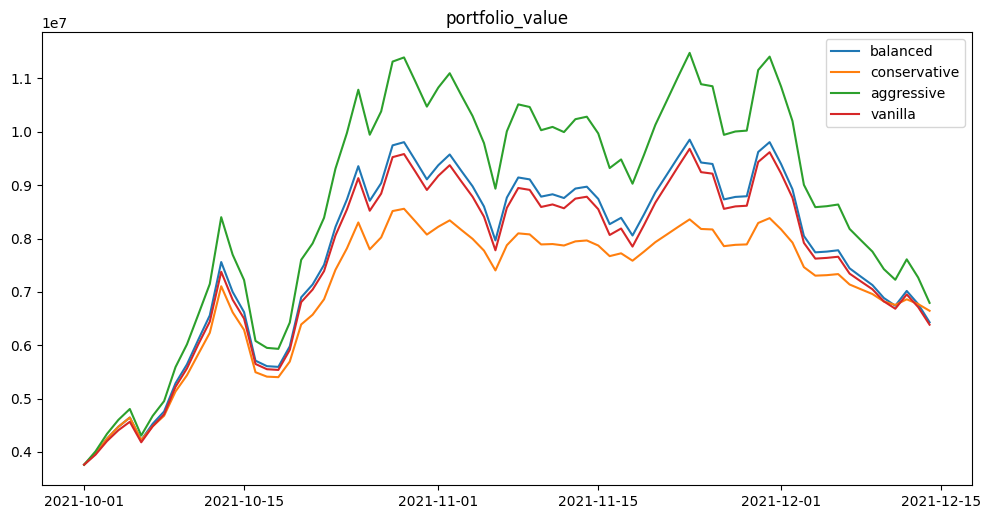

In [ ]:
x = results_df_vanilla.index
y1 = results_df_balanced['portfolio_value']
y2 = results_df_conservative['portfolio_value']
y3 = results_df_aggressive['portfolio_value']
y4 = results_df_vanilla['portfolio_value']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("portfolio_value")
plt.legend()
plt.show()

In [ ]:
y1 = results_df_balanced['stable_amount'][-1]
y2 = results_df_conservative['stable_amount'][-1]
y3 = results_df_aggressive['stable_amount'][-1]
y4 = results_df_vanilla['stable_amount'][-1]

In [ ]:
print(y1, y2, y3, y4)

1824618.3490993567 4919390.814514269 413628.8464212666 1935116.1752690654


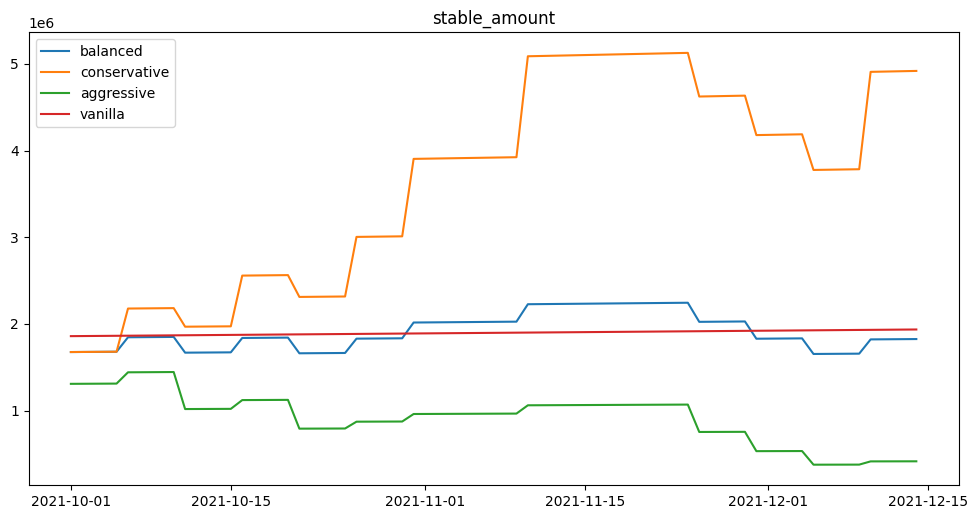

In [ ]:
x = results_df_vanilla.index
y1 = results_df_balanced['stable_amount']
y2 = results_df_conservative['stable_amount']
y3 = results_df_aggressive['stable_amount']
y4 = results_df_vanilla['stable_amount']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("stable_amount")
plt.legend()
plt.show()

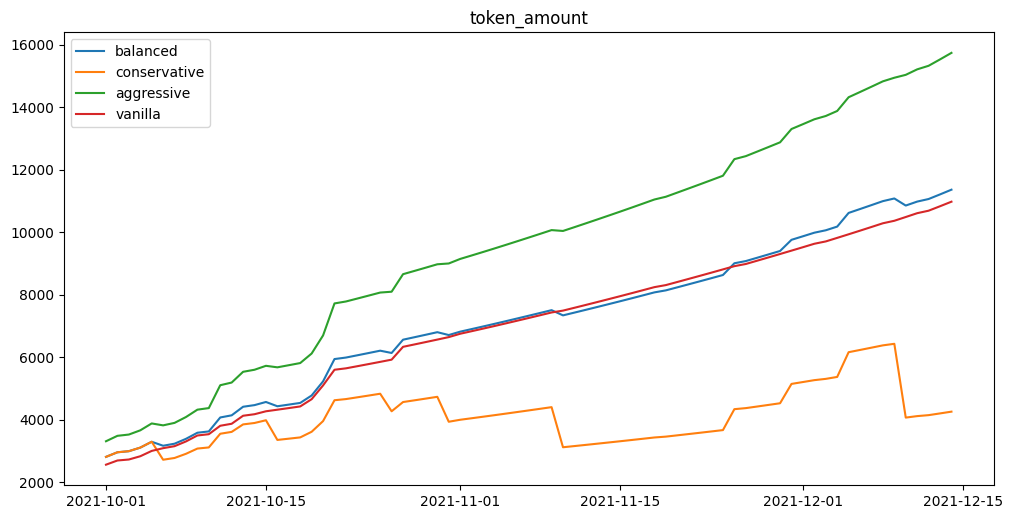

In [ ]:
x = results_df_vanilla.index
y1 = results_df_balanced['token_amount']
y2 = results_df_conservative['token_amount']
y3 = results_df_aggressive['token_amount']
y4 = results_df_vanilla['token_amount']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("token_amount")
plt.legend()
plt.show()

## gohm simulation

In [ ]:
new_csi_df

,ethereum,bitcoin,stable_dom_factor,signal,signal_90d,signal_60d,signal_30d,signal_15d,signal_90d_percentile,signal_60d_percentile,signal_30d_percentile,signal_15d_percentile
time,,,,,,,,,,,,
2020-01-02,1.423059e+10,1.304230e+11,0.050172,2.980293e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1.385979e+10,1.262808e+11,0.051806,2.149107e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,1.461319e+10,1.327663e+11,0.049223,-2.526127e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1.463621e+10,1.334747e+11,0.049001,8.094698e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,1.473883e+10,1.333890e+11,0.048953,2.039732e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14,3.880399e+11,8.065109e+11,0.138715,1.107349e-05,-0.000054,0.000131,-0.000042,0.000004,20.427236,83.044059,22.696929,51.668892
2022-01-15,3.946646e+11,8.161293e+11,0.137056,1.413861e-05,0.000009,0.000208,0.000044,-0.000004,52.069426,88.384513,74.098798,43.124166
2022-01-16,3.968992e+11,8.168003e+11,0.136901,-2.284599e-05,-0.000073,0.000144,0.000033,-0.000042,16.154873,83.978638,70.093458,22.162884


In [ ]:
# make csi_df same length as ohm_market
len = ohm_market_df.index.size
new_csi_df = new_csi_df[-len:]

In [ ]:
# make trade signal column
new_csi_df['trade_signal'] = new_csi_df['signal_15d'] > new_csi_df['signal_30d'] # when 15d > 30d, sell. When 30d > 15day, buy

# cut off data to be less than trade_signal data
ohm_market_df = ohm_market_df[:-5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# gohm simulation!
start_price = ohm_backtest_df['ohmPrice'].iloc[0]
start_gohm_price = ohm_market_df['indexed_price_usd'].iloc[0]

# starting position is 100k USD total value
starting_stablecoin_value = 50000
starting_gohm_position = 50000/start_gohm_price

# instantiate model classes
model_balanced_gohm = backtest_model(ohm_market_df, new_csi_df, buy_trade_size = .1, sell_trade_size = .1)
model_conservative_gohm = backtest_model(ohm_market_df, new_csi_df, buy_trade_size = .1, sell_trade_size = .3)
model_aggressive_gohm = backtest_model(ohm_market_df, new_csi_df, buy_trade_size = .3, sell_trade_size = .1)
model_vanilla_gohm = backtest_model(ohm_market_df, new_csi_df)


# generate trades
trades_df_gohm = model_balanced_gohm.calc_trades()

# set trades for non-vanilla models
model_balanced_gohm.trades_df = trades_df_gohm
model_conservative_gohm.trades_df = trades_df_gohm
model_aggressive_gohm.trades_df = trades_df_gohm

In [ ]:
results_df_balanced_gohm = model_balanced_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_conservative_gohm = model_conservative_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_aggressive_gohm = model_aggressive_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_vanilla_gohm = model_vanilla_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value, vanilla=True)

trades_counter 13
trades_counter 13
trades_counter 13
trades_counter 0


In [ ]:
results_df_balanced_gohm.columns

Index(['token_amount', 'stable_amount', 'indexed_price_usd',
       'portfolio_value'],
      dtype='object')

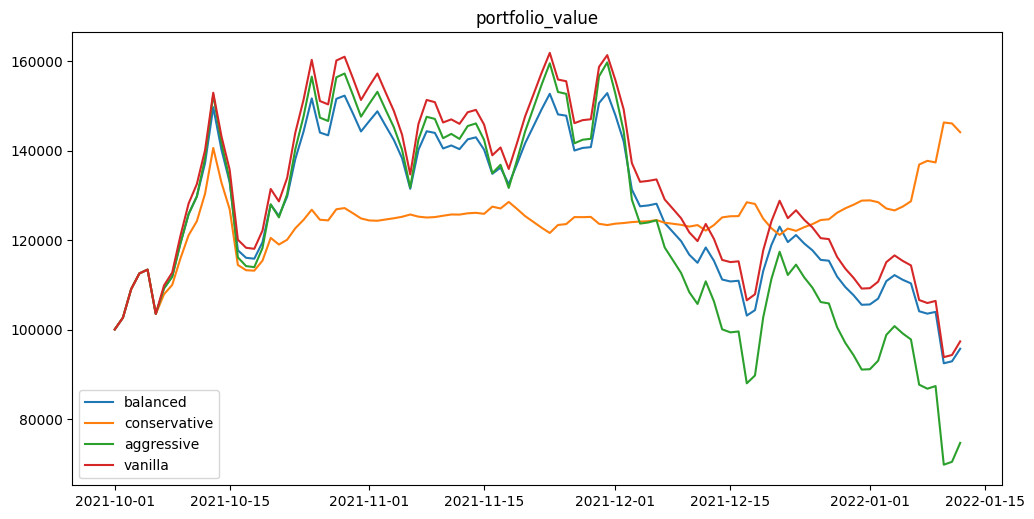

In [ ]:
x = results_df_vanilla_gohm.index
y1 = results_df_balanced_gohm['portfolio_value']
y2 = results_df_conservative_gohm['portfolio_value']
y3 = results_df_aggressive_gohm['portfolio_value']
y4 = results_df_vanilla_gohm['portfolio_value']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("portfolio_value")
plt.legend()
plt.show()

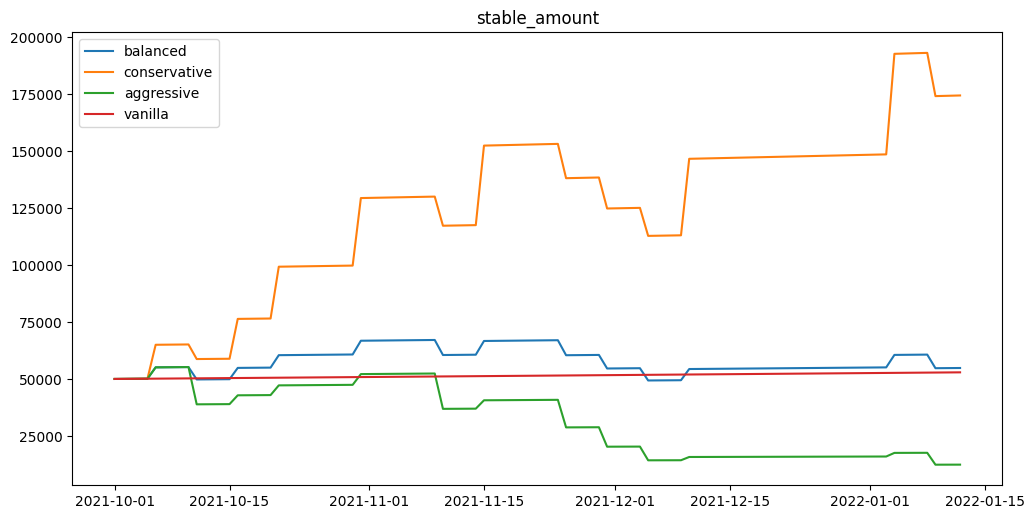

In [ ]:
x = results_df_vanilla_gohm.index
y1 = results_df_balanced_gohm['stable_amount']
y2 = results_df_conservative_gohm['stable_amount']
y3 = results_df_aggressive_gohm['stable_amount']
y4 = results_df_vanilla_gohm['stable_amount']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("stable_amount")
plt.legend()
plt.show()

In [ ]:
results_df_conservative_gohm['stable_amount'][-1]

174423.5473286563

In [ ]:
results_df_conservative_gohm.tail(1)

,token_amount,stable_amount,indexed_price_usd,portfolio_value
timestamp,,,,
2022-01-12,-2.285729,174423.547329,13250.811323,144135.78734
